# **Predict Stroke**

- Import Library

In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping


- Load Data

In [87]:
df = pd.read_csv('../dataset/housing.csv')

In [88]:
df['price_category'] = pd.qcut(df['median_house_value'], q=3, labels=[0, 1, 2])

In [89]:
df.head()
df['price_category'] = df['price_category'].astype(int)

## Data Preprocessing

- Handling Missing & Duplicated Values

In [90]:
df.duplicated().sum()

np.int64(0)

In [91]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [92]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
price_category        0
dtype: int64

In [93]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,price_category
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909,0.999806
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874,0.816635
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,2.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,2.000000


In [94]:
numeric = df.select_dtypes(include=['number']).columns
for col in numeric:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))


In [95]:
# Feature Engineering tambahan
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [96]:
# Misal kita pakai median_house_value untuk klasifikasi → kelompokkan harga rumah
df['price_category'] = pd.qcut(df['median_house_value'], q=3, labels=[0, 1, 2])  # klasifikasi 3 kelas

# Drop target asli (median_house_value) dan kolom non-numerik jika perlu
df.drop('median_house_value', axis=1, inplace=True)

# Jika ada kolom kategorikal (object), encode
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])
    
for col in df.select_dtypes(include='category').columns:
    df[col] = df[col].astype(int)

# Pisahkan fitur dan label
X = df.drop('price_category', axis=1)
y = df['price_category']

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


- Feature Engineering

In [97]:
# Debug bentuk data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print("Label unik:", np.unique(y_train))

X_train shape: (16512, 12)
y_train shape: (16512,)
Label unik: [0 1 2]


## Modelling & Evaluation

In [98]:
# Bangun model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early = EarlyStopping(patience=10, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    callbacks=[early],
                    verbose=1)

Epoch 1/100


c:\Users\lenovo\Downloads\capstone\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6289 - loss: 0.8198 - val_accuracy: 0.7410 - val_loss: 0.5907
Epoch 2/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7313 - loss: 0.6200 - val_accuracy: 0.7493 - val_loss: 0.5819
Epoch 3/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7403 - loss: 0.5995 - val_accuracy: 0.7466 - val_loss: 0.5692
Epoch 4/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7464 - loss: 0.5706 - val_accuracy: 0.7401 - val_loss: 0.5873
Epoch 5/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7524 - loss: 0.5695 - val_accuracy: 0.7471 - val_loss: 0.5642
Epoch 6/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7504 - loss: 0.5720 - val_accuracy: 0.7575 - val_loss: 0.5546
Epoch 7/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7557 - loss: 0.5589 - val_accuracy: 0.7565 - val_loss: 0.5498
Epoch 8/100
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7589 - loss: 0.5589 - val_accuracy: 0.7643

In [99]:
loss, acc = model.evaluate(X_test, y_test)
print("Akurasi:", acc)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7786 - loss: 0.4960
Akurasi: 0.7880329489707947
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1377
           1       0.68      0.75      0.71      1375
           2       0.86      0.77      0.81      1376

    accuracy                           0.79      4128
   macro avg       0.79      0.79      0.79      4128
weighted avg       0.79      0.79      0.79      4128



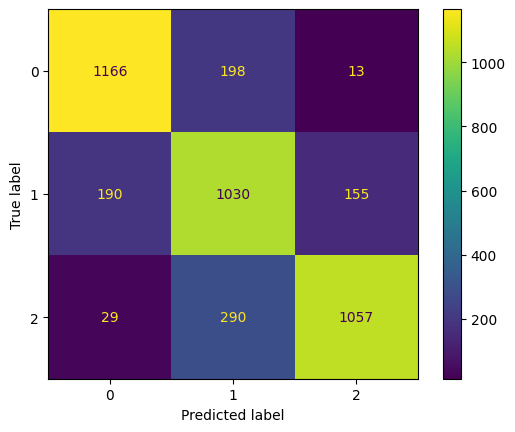

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes)
plt.show()


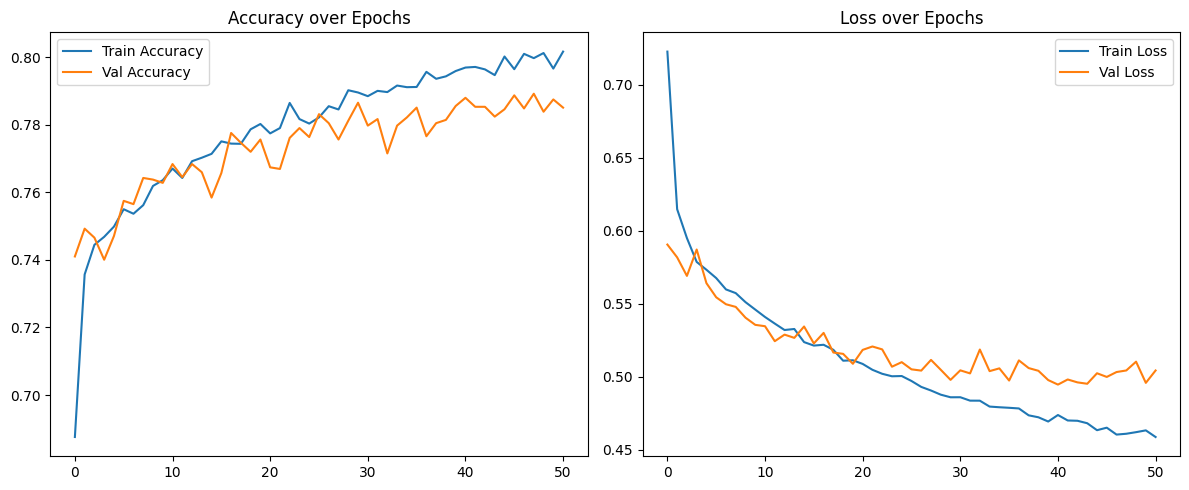

In [101]:
# Visualisasi training accuracy dan loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

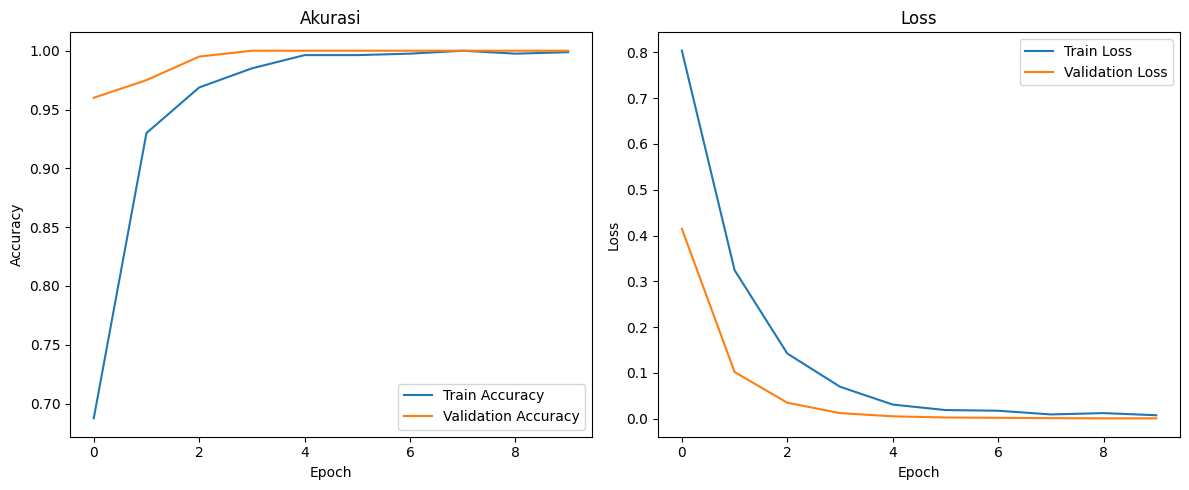

In [ ]:
# plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Akurasi')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# cnn_model = Sequential([
#     Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     GlobalAveragePooling1D(),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# cnn_model.fit(X_train_cnn, y_train, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20


d:\ML\ML-PredictNumerical\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9518 - loss: 0.4005 - val_accuracy: 0.9580 - val_loss: 0.1825
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9499 - loss: 0.2163 - val_accuracy: 0.9580 - val_loss: 0.1621
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9496 - loss: 0.1994 - val_accuracy: 0.9580 - val_loss: 0.1539
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9530 - loss: 0.1856 - val_accuracy: 0.9580 - val_loss: 0.1520
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9521 - loss: 0.1820 - val_accuracy: 0.9580 - val_loss: 0.1486
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9470 - loss: 0.1939 - val_accuracy: 0.9580 - val_loss: 0.1504
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9430 - loss: 0.2043 - val_accuracy: 0.9580 - val_loss: 0.1479
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9437 - loss: 0.2033 - val_accuracy: 0.9580 - val_loss: 0.1493
Epo

## Predict